# Imports and Setup

In [1]:
# lib
import sys

sys.path.append("..")

# set cwd one up
import os

os.chdir("..")
path = "data/hes/Hes1_example.csv"

os.getcwd()
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [2]:
from gpcell import plots
import numpy as np

### Setting up params

In [3]:
par1 = np.array([300, 1, 0.07, 0.07, 1, 1, 0], dtype=np.float64)
par2 = np.array([100, 3, 0.03, 0.03, 1, 1, 18], dtype=np.float64)
n_cells = 500  # total replicates used in the simulation
t_final_vals = [1500, 600]  # 25/10 hours
noise_vals = [np.sqrt(x) for x in [0.1, 0.5]]

sim_params = [[noise, t_final_vals[0], n_cells] for noise in noise_vals]
sim_params.append([noise_vals[0], t_final_vals[1], n_cells])

path = "data/matlab/"
paths = [
    path + f"noise_{round(noise**2, 2)}_time_{t_final}_rep_{n_cells}.csv"
    for noise, t_final, n_cells in sim_params
]


# Simulation

In [ ]:
from gpcell.utils import get_time_series

# --- generate data for plot --- #
# XY = [
#     utils.get_time_series(par1, par2, t_final, noise, n_cells, path=path, mode="x")
#     for path, (noise, t_final, n_cells) in zip(paths, sim_params)
# ]

for path, (noise, t_final, n_cells) in zip(paths, sim_params):
    get_time_series(par1, par2, t_final, noise, n_cells, path=path, mode="x")

# # save data
# for xy, path in zip(XY, paths):
#     utils.save_sim(xy[0], xy[1], path)


In [ ]:
# from gpcell.backend import _simulate_replicate_mod9

# --------------------------------#
# --- test simulate functions --- #
# --------------------------------#

# --- test speed --- #
# %timeit XY = [utils.get_time_series(par1, par2, t_final, noise, n_cells) for noise, t_final, n_cells in sim_params]

# --- test load data --- #
# import pandas as pd
# df = pd.read_csv(paths[0])
# print(df.drop(columns="Time").shape[1])

# --- test simulate --- #
# X, Y = utils.get_time_series(par1, par2, t_final_vals[0], noise_vals[0], n_cells)
# print(len(X), len(Y))
# print(X[0].shape, Y[0].shape)

# ROC Dev

## Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
from gpcell.utils import get_time_series

# --- Function parameters --- #
filename = paths[0]
noise, t_final, n_cells = sim_params[0]
joblib = True


# ----------------------------#
# --- Function definition --- #
# ----------------------------#

# --- Read the generated data  --- #
# The CSV file is assumed to have a "Time" column (in hours) and then 2*n_cells columns for the simulated data.
x, y_list = get_time_series(
    par1, par2, t_final, noise, n_cells, path=filename, mode="r"
)
total_columns = len(y_list)

if total_columns != 2 * n_cells:
    raise ValueError(
        f"Expected 2*n_cells = {2 * n_cells} columns, but CSV has {total_columns} columns."
    )



## Logic

In [ ]:
from gpcell import OscillatorDetector
from gpcell.backend.priors import sim_ou_prior, sim_ouosc_prior

# --- Fit detector--- #
params = {
    "verbose": True,
    "joblib": joblib,
    "plots": ["BIC"],
    "set_noise": noise,
    "detrend": False,
    "ou_prior_gen": sim_ou_prior,
    "ouosc_prior_gen": sim_ouosc_prior,
}
od = OscillatorDetector.from_file(filename, "Time", "Cell", "Cell", params=params)
od.fit("BIC")
BICdiffM = od.BIC_diffs  # list or array with length equal to total_columns
BICdiffTOT = np.array(BICdiffM)


# --- ROC analysis using BIC differences --- #
# Split BIC differences into two groups: A (first n_cells) and B (next n_cells)
A = BICdiffTOT[:n_cells]
B = BICdiffTOT[n_cells : 2 * n_cells]
print(A.shape, B.shape)

# Define a threshold vector spanning a little below the min to a little above the max.
thresholds = np.linspace(BICdiffTOT.min() - 1, BICdiffTOT.max() + 1, 200)
FP1 = np.zeros_like(thresholds)
TP1 = np.zeros_like(thresholds)
for i, th in enumerate(thresholds):
    FP1[i] = np.sum(A > th)
    TP1[i] = np.sum(B > th)

# --- Plot BIC curve --- #
od.bic_plot

In [ ]:
thrvec = np.exp(np.linspace(-15, 0, 200))
n_thr = len(thrvec)
n_series = len(y_list)

# Preallocate a matrix to store detection results:
# rows: time series; columns: thresholds
beatmat = np.empty((n_series, n_thr), dtype=int)

# Loop once over all time series to compute their periodograms
for i, y in enumerate(y_list):
    ls = LombScargle(x, y)
    frequency, power = ls.autopower(normalization="standard")
    # For each threshold, compute false alarm level and determine detection
    for j, thr in enumerate(thrvec):
        pth = ls.false_alarm_level(thr)
        beatmat[i, j] = int(np.any(power > pth))

# Compute False Positives (FP) and True Positives (TP) vectorized over thresholds.
# Note: following the original code's convention:
#   - First half of y_list are considered oscillatory signals.
#   - Second half are non-oscillatory.
FP2 = (
    np.sum(beatmat[:n_cells, :], axis=0) / n_cells
)  # fraction detected among first half
TP2 = (
    np.sum(beatmat[n_cells:, :], axis=0) / n_cells
)  # fraction detected among second half


In [ ]:
plt.figure(figsize=(6, 4), dpi=150)  # Increase DPI for higher definition

# Plot lines with thinner width and possibly a z-order to be on top of grid
plt.plot(FP1 / n_cells, TP1 / n_cells, label="GP", lw=1, color="red", zorder=2)
plt.plot(FP2, TP2, label="L-S", lw=1, color="blue", zorder=2)

# Plot the diagonal reference line
plt.plot([0, 1], [0, 1], lw=1, linestyle="--", color="gray", zorder=1)

# Axis limits
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])

# Axis labels, title, legend
plt.xlabel("1 - Specificity (false positive rate)")
plt.ylabel("Sensitivity (true positive rate)")
plt.title("ROC Curve")
plt.legend(loc="lower right")

# If you have a grid, you can draw it behind the lines:
# plt.grid(True, zorder=0)

plt.tight_layout()  # Better spacing
plt.show()


### Test run

In [ ]:
path, (noise, t_final, n_cells) = paths[0], sim_params[0]
FP1, TP1, FP2, TP2 = plots.compute_rocs_from_file(path, noise, n_cells, joblib=True)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4), dpi=150)  # Increase DPI for higher definition

# Plot lines with thinner width and possibly a z-order to be on top of grid
plt.plot(FP1 / n_cells, TP1 / n_cells, label="GP", lw=1, color="red", zorder=2)
plt.plot(FP2, TP2, label="L-S", lw=1, color="blue", zorder=2)

# Plot the diagonal reference line
plt.plot([0, 1], [0, 1], lw=1, linestyle="--", color="gray", zorder=1)

# Axis limits
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])

# Axis labels, title, legend
plt.xlabel("1 - Specificity (false positive rate)")
plt.ylabel("Sensitivity (true positive rate)")
plt.title("ROC Curve")
plt.legend(loc="lower right")

# If you have a grid, you can draw it behind the lines:
# plt.grid(True, zorder=0)

plt.tight_layout()  # Better spacing
plt.show()


# Full run

In [4]:
# calculate ROC
fp1_vals, fp2_vals, tp1_vals, tp2_vals = [], [], [], []
for path, (noise, t_final, n_cells) in zip(paths, sim_params):
    fp1, tp1, fp2, tp2 = plots.compute_rocs_from_file(path, noise, n_cells, joblib=True)
    fp1_vals.append(fp1)
    tp1_vals.append(tp1)
    fp2_vals.append(fp2)
    tp2_vals.append(tp2)


Starting Oscillator Detector...

Overriding default value for verbose
Overriding default value for plots
Overriding default value for set_noise
Overriding default value for joblib
Overriding default value for ou_prior_gen
Overriding default value for ouosc_prior_gen

Loaded data with 1000 cells, noise set to 0.31622776601683794
Plots: on

Fitting BIC...

Homogenous traces: 1000 cells, pre_dispatch: n_jobs, batch_size: auto


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  36 tasks      | elapsed:   11.6s
/Users/tsd/miniforge3/envs/gpcell/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=14)]: Done 186 tasks      | elapsed:   32.3s
[Parallel(n_jobs=14)]: Done 436 tasks      | elapsed:  1.4min
[Parallel(n_jobs=14)]: Done 786 tasks      | elapsed:  2.4min
[Parallel(n_jobs=14)]: Done 1000 out of 1000 | elapsed:  3.0min finished



Homogenous traces: 1000 cells, pre_dispatch: n_jobs, batch_size: auto


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  36 tasks      | elapsed:   14.2s
[Parallel(n_jobs=14)]: Done 186 tasks      | elapsed:   55.4s
[Parallel(n_jobs=14)]: Done 436 tasks      | elapsed:  1.8min
[Parallel(n_jobs=14)]: Done 786 tasks      | elapsed:  3.3min
[Parallel(n_jobs=14)]: Done 1000 out of 1000 | elapsed:  4.2min finished



Number of cells counted as oscillatory (BIC method): 477/1000

Starting Oscillator Detector...

Overriding default value for verbose
Overriding default value for plots
Overriding default value for set_noise
Overriding default value for joblib
Overriding default value for ou_prior_gen
Overriding default value for ouosc_prior_gen

Loaded data with 1000 cells, noise set to 0.7071067811865476
Plots: on

Fitting BIC...

Homogenous traces: 1000 cells, pre_dispatch: n_jobs, batch_size: auto


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  36 tasks      | elapsed:   11.3s
[Parallel(n_jobs=14)]: Done 186 tasks      | elapsed:   33.0s
/Users/tsd/miniforge3/envs/gpcell/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=14)]: Done 436 tasks      | elapsed:  1.3min
[Parallel(n_jobs=14)]: Done 786 tasks      | elapsed:  2.4min
[Parallel(n_jobs=14)]: Done 1000 out of 1000 | elapsed:  2.9min finished



Homogenous traces: 1000 cells, pre_dispatch: n_jobs, batch_size: auto


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  36 tasks      | elapsed:   14.1s
[Parallel(n_jobs=14)]: Done 186 tasks      | elapsed:   52.6s
[Parallel(n_jobs=14)]: Done 436 tasks      | elapsed:  1.9min
[Parallel(n_jobs=14)]: Done 786 tasks      | elapsed:  3.4min
[Parallel(n_jobs=14)]: Done 1000 out of 1000 | elapsed:  4.2min finished


Cell 81 has NaNs in the model fitting
Cell 81 has NaNs in the model fitting after 5 attempts

Number of cells counted as oscillatory (BIC method): 295/1000

Starting Oscillator Detector...

Overriding default value for verbose
Overriding default value for plots
Overriding default value for set_noise
Overriding default value for joblib
Overriding default value for ou_prior_gen
Overriding default value for ouosc_prior_gen

Loaded data with 1000 cells, noise set to 0.31622776601683794
Plots: on

Fitting BIC...

Homogenous traces: 1000 cells, pre_dispatch: n_jobs, batch_size: auto


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  36 tasks      | elapsed:    8.4s
[Parallel(n_jobs=14)]: Done 186 tasks      | elapsed:   28.9s
/Users/tsd/miniforge3/envs/gpcell/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=14)]: Done 436 tasks      | elapsed:  1.3min
[Parallel(n_jobs=14)]: Done 786 tasks      | elapsed:  2.2min
[Parallel(n_jobs=14)]: Done 1000 out of 1000 | elapsed:  2.8min finished



Homogenous traces: 1000 cells, pre_dispatch: n_jobs, batch_size: auto


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  36 tasks      | elapsed:   13.4s
[Parallel(n_jobs=14)]: Done 186 tasks      | elapsed:   51.3s
[Parallel(n_jobs=14)]: Done 436 tasks      | elapsed:  1.9min
[Parallel(n_jobs=14)]: Done 786 tasks      | elapsed:  3.3min
[Parallel(n_jobs=14)]: Done 1000 out of 1000 | elapsed:  4.2min finished



Number of cells counted as oscillatory (BIC method): 318/1000


=== Debug Info: Checking shapes and partial data ===
dataNORMED1 shape: (51, 1000)
dataNORMED2 shape: (51, 1000)
dataNORMED3 shape: (21, 1000)
FP11[:5]: [500. 500. 500. 500. 500.] TP11[:5]: [500. 500. 500. 500. 500.]
FP21[:5]: [0. 0. 0. 0. 0.] TP21[:5]: [0. 0. 0. 0. 0.]
FP12[:5]: [500. 500. 500. 500. 500.] TP12[:5]: [500. 500. 500. 500. 500.]
FP22[:5]: [0. 0. 0. 0. 0.] TP22[:5]: [0. 0. 0. 0. 0.]
FP13[:5]: [500. 500. 500. 500. 500.] TP13[:5]: [500. 500. 500. 500. 500.]
FP23[:5]: [0. 0. 0. 0. 0.] TP23[:5]: [0. 0. 0. 0. 0.]


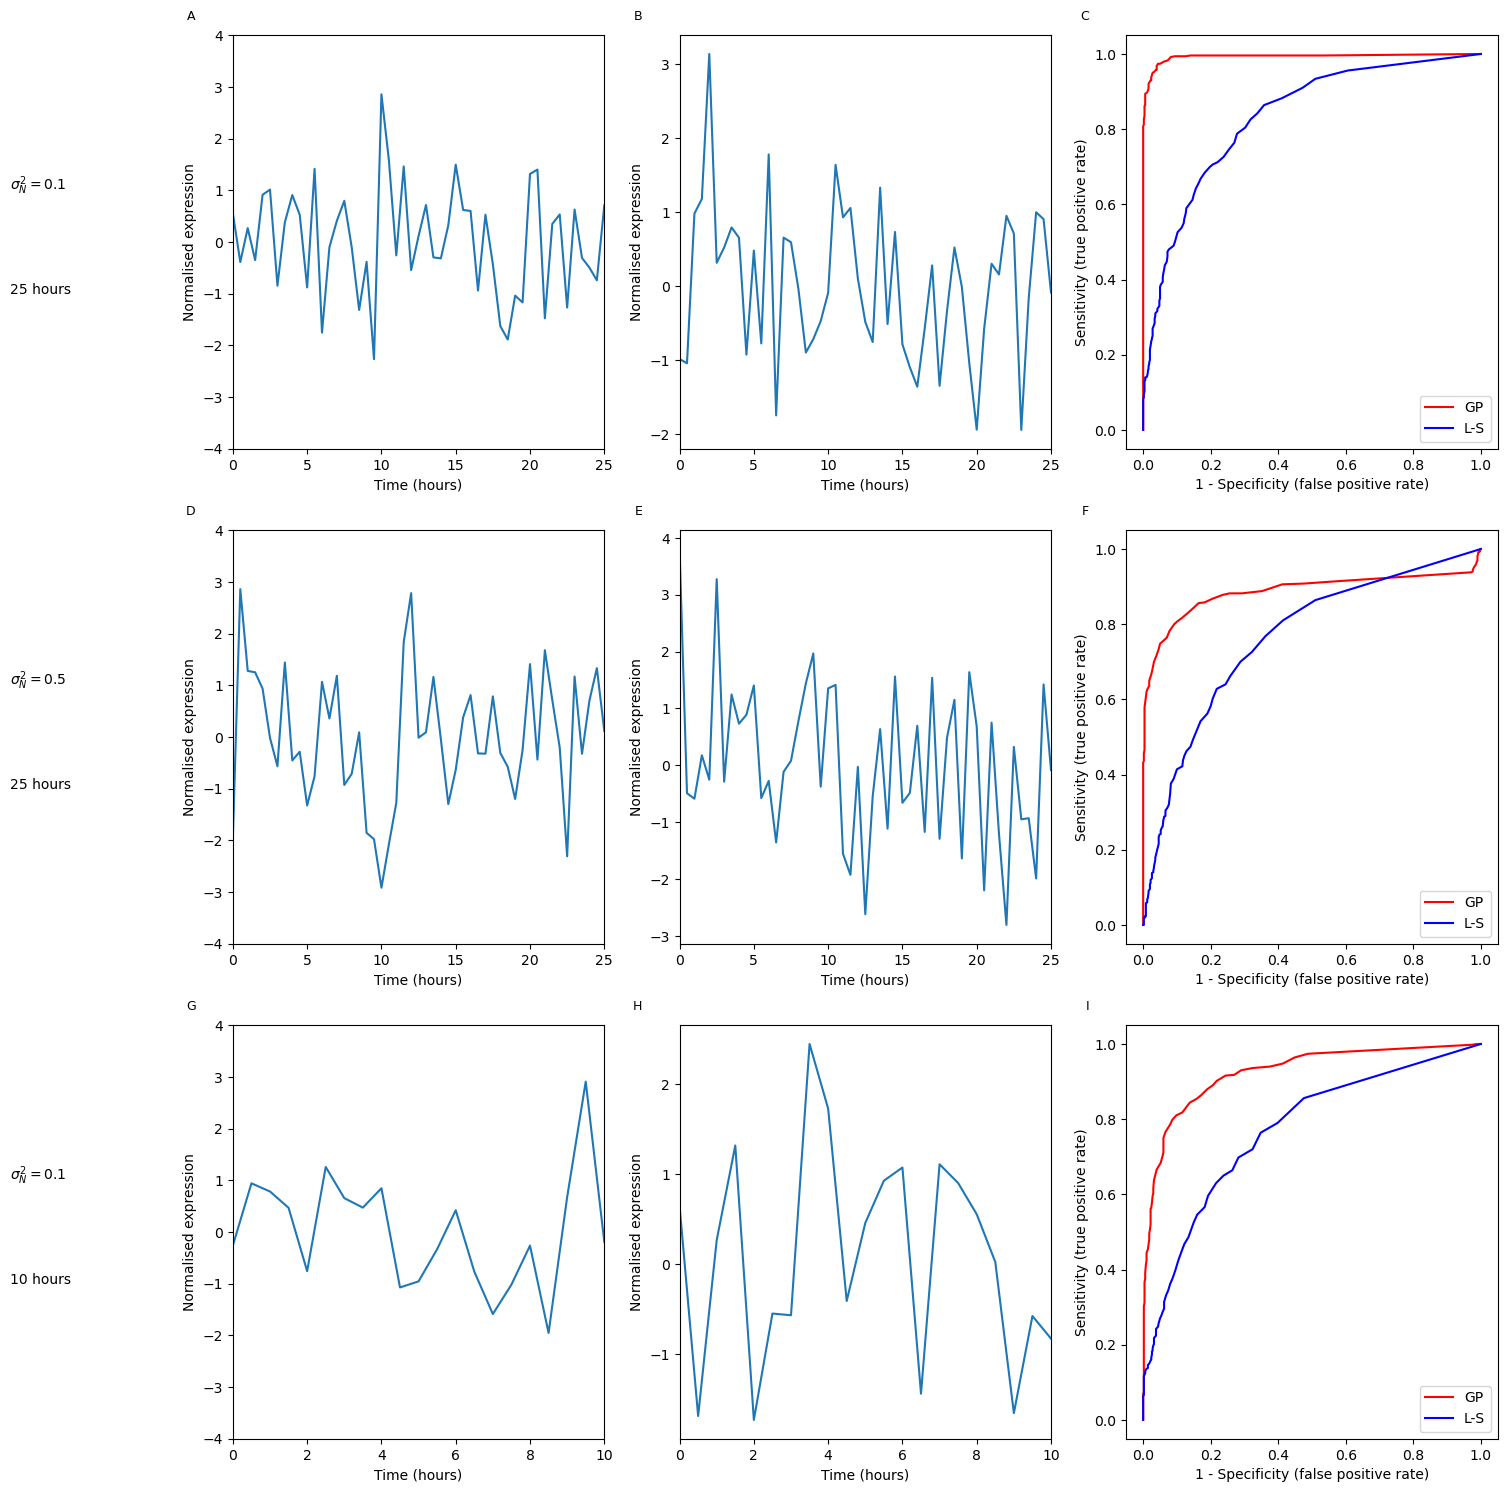

In [5]:
import pandas as pd

# plot ROC
x_arr = []
dataNormed_arr = []

for path in paths:
    df = pd.read_csv(path)

    x = df["Time"].values
    dataNormed = df.drop(columns=["Time"]).values

    x_arr.append(x)
    dataNormed_arr.append(dataNormed)

plots.plot_rocs_and_timeseries(
    x_arr[0],
    dataNormed_arr[0],
    fp1_vals[0],
    tp1_vals[0],
    fp2_vals[0],
    tp2_vals[0],
    x_arr[1],
    dataNormed_arr[1],
    fp1_vals[1],
    tp1_vals[1],
    fp2_vals[1],
    tp2_vals[1],
    x_arr[2],
    dataNormed_arr[2],
    fp1_vals[2],
    tp1_vals[2],
    fp2_vals[2],
    tp2_vals[2],
    n_cells,
)